
##  Feature 2: Social Media 

### Fake News Detection on Social Media:

Fake news detection on social media 
- Characterization
- Detection
Future directions and open issues for fake news detection on social media.
- Data-oriented
- Feature-oriented
- Model-oriented
- Application-oriented

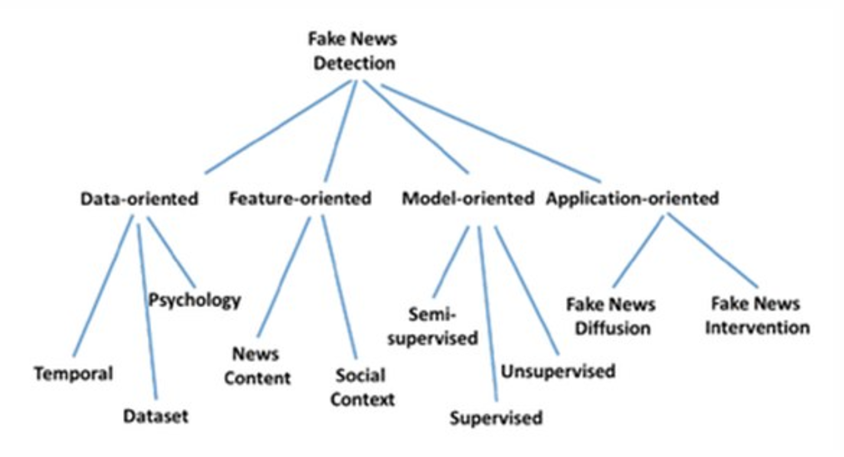

## Features for the Alternus Vera and importance as determined from the readings and documents

- Political affiliation - Kaggle /Liar -Liar + NYT + Guardian - 26%
- Social Media (yellow press + internet) - https://github.com/KaiDMML/FakeNewsNet + Kaggel dataset - 7%
- Bias - https://github.com/clips/news-audit - 25%
- Hate News - 8%
- Credibility - 24%
- Fact checks https://github.com/sumeetkr/AwesomeFakeNews + dataset in the git link - 10%


## WorkFlow

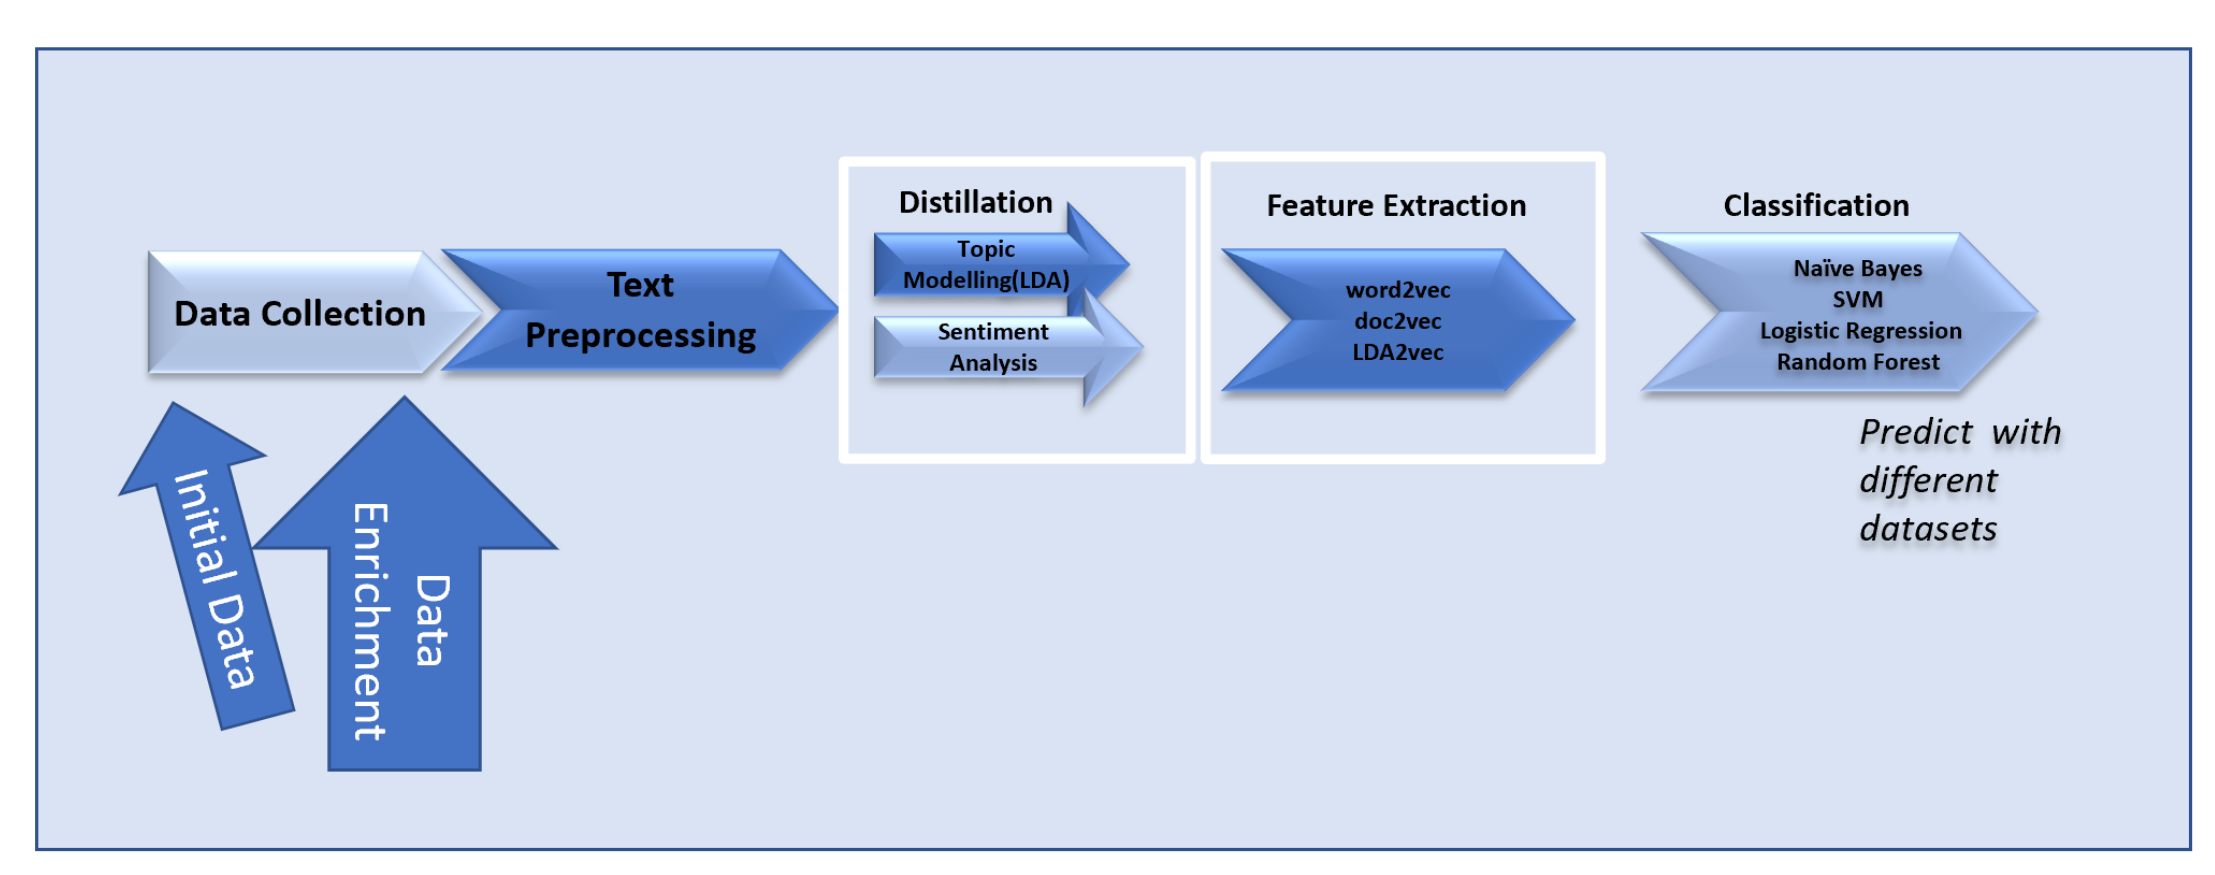


### Step 1: Load the dataset

The dataset we'll use is the 20newsgroup dataset that is available from sklearn. This dataset has news articles grouped into 20 news categories


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import pickle 
#import mglearn
import time


from nltk.tokenize import TweetTokenizer # doesn't split at apostrophes
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline


In [25]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True)
newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True)

In [26]:


print(list(newsgroups_train.target_names))



['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [27]:
# Lets look at some sample news
newsgroups_train.data[:2]

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

In [28]:
print(newsgroups_train.filenames.shape, newsgroups_train.target.shape)

(11314,) (11314,)



### Step 2: Data Preprocessing

Below are the steps followed for data preprocessing 

    - Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
    - Words that have fewer than 3 characters are removed.
    - All stopwords are removed.
    - Words are lemmatized - words in third person are changed to first person and verbs in past and future tenses are changed into present.
    - Words are stemmed - words are reduced to their root form.



In [29]:


'''
Loading Gensim and nltk libraries
'''
# pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)



In [30]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anuks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Lemmatizer Example

Before preprocessing our dataset, let's first look at an lemmatizing example. What would be the output if we lemmatized the word 'went':


In [31]:
print(WordNetLemmatizer().lemmatize('went', pos = 'v')) # past tense to present tense

go


### Stemmer Example

Let's also look at a stemming example. Let's throw a number of words at the stemmer and see how it deals with each one:


In [32]:
import pandas as pd
stemmer = SnowballStemmer("english")
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]

pd.DataFrame(data={'original word':original_words, 'stemmed':singles })

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [33]:
'''
Write a function to perform the pre processing steps on the entire dataset
'''
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [34]:
'''
Preview a document after preprocessing
'''
document_num = 50
doc_sample = 'This disk has failed many times. I would like to get it replaced.'

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['This', 'disk', 'has', 'failed', 'many', 'times.', 'I', 'would', 'like', 'to', 'get', 'it', 'replaced.']


Tokenized and lemmatized document: 
['disk', 'fail', 'time', 'like', 'replac']




Let's now preprocess all the news headlines we have. To do that, we iterate over the list of documents in our training sample


In [35]:
processed_docs = []

for doc in newsgroups_train.data:
    processed_docs.append(preprocess(doc))

In [36]:
'''
Preview 'processed_docs'
'''
print(processed_docs[:2])

[['lerxst', 'thing', 'subject', 'nntp', 'post', 'host', 'organ', 'univers', 'maryland', 'colleg', 'park', 'line', 'wonder', 'enlighten', 'door', 'sport', 'look', 'late', 'earli', 'call', 'bricklin', 'door', 'small', 'addit', 'bumper', 'separ', 'rest', 'bodi', 'know', 'tellm', 'model', 'engin', 'spec', 'year', 'product', 'histori', 'info', 'funki', 'look', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst'], ['guykuo', 'carson', 'washington', 'subject', 'clock', 'poll', 'final', 'summari', 'final', 'clock', 'report', 'keyword', 'acceler', 'clock', 'upgrad', 'articl', 'shelley', 'qvfo', 'innc', 'organ', 'univers', 'washington', 'line', 'nntp', 'post', 'host', 'carson', 'washington', 'fair', 'number', 'brave', 'soul', 'upgrad', 'clock', 'oscil', 'share', 'experi', 'poll', 'send', 'brief', 'messag', 'detail', 'experi', 'procedur', 'speed', 'attain', 'rat', 'speed', 'card', 'adapt', 'heat', 'sink', 'hour', 'usag', 'floppi', 'disk', 'function', 'floppi', 'especi', 'request', 'summar', 'day',

### Step 3: Bag of words on the dataset

In [37]:


'''
Create a dictionary from 'processed_docs' containing the number of times a word appears 
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
dictionary = gensim.corpora.Dictionary(processed_docs)



In [38]:
'''
Checking dictionary created
'''
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 addit
1 bodi
2 bricklin
3 bring
4 bumper
5 call
6 colleg
7 door
8 earli
9 engin
10 enlighten


In [39]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
'''
Preview BOW for our sample preprocessed document
'''
document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 13 ("host") appears 1 time.
Word 18 ("line") appears 1 time.
Word 24 ("nntp") appears 1 time.
Word 25 ("organ") appears 1 time.
Word 27 ("post") appears 1 time.
Word 29 ("rest") appears 1 time.
Word 34 ("subject") appears 1 time.
Word 37 ("thing") appears 5 time.
Word 115 ("give") appears 1 time.
Word 128 ("like") appears 1 time.
Word 138 ("peopl") appears 1 time.
Word 212 ("write") appears 1 time.
Word 221 ("clear") appears 1 time.
Word 338 ("say") appears 1 time.
Word 386 ("think") appears 1 time.
Word 437 ("refer") appears 1 time.
Word 452 ("true") appears 1 time.
Word 504 ("technolog") appears 1 time.
Word 564 ("christian") appears 1 time.
Word 582 ("exampl") appears 1 time.
Word 607 ("jew") appears 1 time.
Word 612 ("lead") appears 1 time.
Word 615 ("littl") appears 3 time.
Word 664 ("wors") appears 2 time.
Word 920 ("keith") appears 3 time.
Word 933 ("punish") appears 1 time.
Word 1016 ("california") appears 1 time.
Word 1083 ("institut") appears 1 time.
Word 1147 ("similar"

### Step 4: Feature Selection - Running LDA using Bag of Words 

In [40]:
# LDA mono-core -- fallback code in case LdaMulticore throws an error on your machine
# lda_model = gensim.models.LdaModel(bow_corpus, 
#                                    num_topics = 10, 
#                                    id2word = dictionary,                                    
#                                    passes = 50)

# LDA multicore 
'''
Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
'''
# TODO
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

In [41]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.011*"write" + 0.011*"organ" + 0.011*"line" + 0.010*"subject" + 0.010*"articl" + 0.007*"space" + 0.007*"post" + 0.006*"like" + 0.005*"nasa" + 0.005*"think"


Topic: 1 
Words: 0.008*"line" + 0.008*"subject" + 0.008*"write" + 0.007*"organ" + 0.007*"year" + 0.006*"armenian" + 0.006*"articl" + 0.006*"know" + 0.005*"like" + 0.005*"think"


Topic: 2 
Words: 0.009*"peopl" + 0.008*"write" + 0.008*"christian" + 0.008*"think" + 0.007*"subject" + 0.006*"know" + 0.006*"line" + 0.006*"believ" + 0.006*"organ" + 0.006*"say"


Topic: 3 
Words: 0.015*"line" + 0.014*"subject" + 0.012*"organ" + 0.009*"post" + 0.007*"univers" + 0.007*"host" + 0.007*"nntp" + 0.006*"window" + 0.006*"write" + 0.005*"mail"


Topic: 4 
Words: 0.012*"line" + 0.011*"subject" + 0.010*"window" + 0.010*"organ" + 0.008*"card" + 0.008*"drive" + 0.006*"write" + 0.006*"scsi" + 0.006*"post" + 0.006*"problem"


Topic: 5 
Words: 0.006*"state" + 0.005*"peopl" + 0.005*"line" + 0.005*"game" + 0.005*"year" + 0.005*"write" + 


Classification of the topics

Using the words in each topic and their corresponding weights, what categories were you able to infer?

    0: Graphics Cards
    1: Religion
    2: Space
    3: Politics
    4: Gun Violence
    5: Technology
    6: Sports
    7: Encryption



###  Step 6: Testing model on a document


In [42]:
num = 100
unseen_document = newsgroups_test.data[num]
print(unseen_document)

Subject: help
From: C..Doelle@p26.f3333.n106.z1.fidonet.org (C. Doelle)
Lines: 13

Hello All!

    It is my understanding that all True-Type fonts in Windows are loaded in
prior to starting Windows - this makes getting into Windows quite slow if you
have hundreds of them as I do.  First off, am I correct in this thinking -
secondly, if that is the case - can you get Windows to ignore them on boot and
maybe make something like a PIF file to load them only when you enter the
applications that need fonts?  Any ideas?


Chris

 * Origin: chris.doelle.@f3333.n106.z1.fidonet.org (1:106/3333.26)



In [43]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.9796140193939209	 Topic: 0.012*"line" + 0.011*"subject" + 0.010*"window" + 0.010*"organ" + 0.008*"card"


In [44]:
print(newsgroups_test.target[num])

2


In [46]:
print(newsgroups_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [48]:
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()


Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories



##  Step 7: Feature Extraction

### Sample pipeline for text feature extraction and evaluation

The dataset used in this example is the 20 newsgroups dataset which will be automatically downloaded and then cached and reused for the document classification example.

You can adjust the number of categories by giving their names to the dataset loader or setting them to None to get the 20 of them.

Here is a sample output of a run on a quad-core machine::

Loading 20 newsgroups dataset for categories: ['alt.atheism', 'talk.religion.misc'] 1427 documents 2 categories

Performing grid search... pipeline: ['vect', 'tfidf', 'clf'] parameters: {'clf__alpha': (1.0000000000000001e-05, 9.9999999999999995e-07), 'clf__max_iter': (10, 50, 80), 'clf__penalty': ('l2', 'elasticnet'), 'tfidf__use_idf': (True, False), 'vect__max_n': (1, 2), 'vect__max_df': (0.5, 0.75, 1.0), 'vect__max_features': (None, 5000, 10000, 50000)} done in 1737.030s

Best score: 0.940 Best parameters set: clf__alpha: 9.9999999999999995e-07 clf__max_iter: 50 clf__penalty: 'elasticnet' tfidf__use_idf: True vect__max_n: 2 vect__max_df: 0.75 vect__max_features: 50000


In [60]:

from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


For each topic, we will explore the words occuring in that topic and its relative weight



In [61]:
# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])


Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories



In [62]:
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (5,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

In [63]:
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data.data, data.target)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (5,),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.2min finished


done in 72.119s

Best score: 0.950
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 5
	clf__penalty: 'elasticnet'
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)


### Vectorize

In [81]:
#creating feature vector - document term matrix
countV = CountVectorizer()
train_count = countV.fit_transform(newsgroups_train)

In [82]:
print(train_count)

  (0, 0)	1
  (1, 3)	1
  (2, 5)	1
  (3, 4)	1
  (4, 1)	1
  (5, 2)	1


In [83]:
#vocab size
train_count.shape

#check vocabulary using below command
print(countV.vocabulary_)

{'data': 0, 'filenames': 3, 'target_names': 5, 'target': 4, 'descr': 1, 'description': 2}


In [69]:
# Instantiate the vectorizer
word_vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{2,}',  #vectorize 2-character words or more
    ngram_range=(1, 1),
    max_features=30000)

In [71]:
# fit and transform on it the training features
word_vectorizer.fit(newsgroups_train)
X_train_word_features = word_vectorizer(newsgroups_train)

#transform the test features to sparse matrix
test_features = word_vectorizer.transform(newsgroups_test)

# transform the holdout text for submission at the end
#holdout_text = holdout['comment_text']
#holdout_word_features = word_vectorizer.transform(holdout_text)

In [74]:
word_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=30000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{2,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [78]:
print(word_vectorizer.vocabulary_)

{'data': 0, 'filenames': 3, 'target_names': 5, 'target': 4, 'descr': 1, 'description': 2}


In [86]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train',categories=categories, shuffle=True, random_state=42)

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(857, 18089)

In [88]:
count_vect.vocabulary_.get(u'algorithm')

1976

In [89]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(857, 18089)

In [90]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(857, 18089)

In [92]:
X_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [104]:
from sklearn.feature_extraction.text import HashingVectorizer
# create the transform
vectorizer = HashingVectorizer(n_features=5)
# encode document
vector = vectorizer.transform(twenty_train.data)
# summarize encoded vector
print(vector.shape)
# a1x1 (7% for social media)
print(vector.toarray() * 0.07)

(857, 5)
[[ 0.01560379  0.05851421  0.01170284  0.02340568  0.02340568]
 [-0.06413231  0.02494034 -0.00712581  0.          0.01068872]
 [-0.03454313  0.04251462  0.02657164  0.03454313  0.        ]
 ...
 [-0.01979487  0.05855981  0.01979487  0.01072222 -0.0239188 ]
 [-0.01800206  0.06480741  0.01080123  0.01440165 -0.00720082]
 [-0.0224777   0.06570405  0.00691622  0.00172905 -0.00518716]]


### Training a Classifier

In [94]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [105]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))


'God is love' => alt.atheism
'OpenGL on the GPU is fast' => alt.atheism


### Building a pipeline

In [97]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
 ])

In [98]:
text_clf.fit(twenty_train.data, twenty_train.target)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Evaluation of the performance on the test set

### Predictive accuracy of the model : 73.6%

In [99]:
import numpy as np
twenty_test = fetch_20newsgroups(subset='test',categories=categories, shuffle=True, random_state=42)
docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target)  

0.7368421052631579

### SVM 

In [100]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([
    ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
 ])

In [101]:
text_clf.fit(twenty_train.data, twenty_train.target)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [102]:
predicted = text_clf.predict(docs_test)

In [103]:
np.mean(predicted == twenty_test.target)

0.8491228070175438

### Accuracy Score : 84.9 %

## Polynomial Equation

### Our % vector polynomial equation values for polynomial equation are as follows,


#### Anu Sebastian
- x1: Political Affiliation - Complex Feature
- x2: Social Media          - Non-complex Feature

#### Ravali Nagabandi    
- x3:Bias                   - Complex Feature
- x4:Credibilty             - Non-complex Feature
        
#### Saloni Sharad Bhalearo 
- x5:Credibilty             - Complex Feature
- x6:Fact Checks            - Non-complex Feature

The polynomial equation is

= a1x1+ a2x2+ a3x3+ a4x4+ a5x5 +a6x6

= 0.26 * x1+ 0.07 * x2+ 0.25 * x3+ 0.08* x4+ 0.24 * x5 +0.1 * x6

=[[-0.09192388 -0.09192388  0.09192388 -0.18384776 -0.09192388]
 [-0.21633308  0.07211103  0.07211103 -0.07211103  0.07211103]
 [-0.05964809  0.11929618 -0.11929618 -0.17894427 -0.05964809]
 ...
 [-0.07211103  0.14422205 -0.14422205 -0.14422205  0.        ]
 [-0.06128259  0.         -0.12256518 -0.18384776  0.12256518]
 [-0.12172279  0.18258419 -0.0304307   0.0608614  -0.12172279]]   +

 [[ 0.01560379  0.05851421  0.01170284  0.02340568  0.02340568]
 [-0.06413231  0.02494034 -0.00712581  0.          0.01068872]
 [-0.03454313  0.04251462  0.02657164  0.03454313  0.        ]
 ...
 [-0.01979487  0.05855981  0.01979487  0.01072222 -0.0239188 ]
 [-0.01800206  0.06480741  0.01080123  0.01440165 -0.00720082]
 [-0.0224777   0.06570405  0.00691622  0.00172905 -0.00518716]]  +
 
[[-0.08838835 -0.08838835  0.08838835 -0.1767767  -0.08838835]
 [-0.20801257  0.06933752  0.06933752 -0.06933752  0.06933752]
 [-0.05735393  0.11470787 -0.11470787 -0.1720618  -0.05735393]
 ...
 [-0.06933752  0.13867505 -0.13867505 -0.13867505  0.        ]
 [-0.05892557  0.         -0.11785113 -0.1767767   0.11785113]
 [-0.11704115  0.17556172 -0.02926029  0.05852057 -0.11704115]]  + 
 
 [[-0.016       0.032       0.         -0.064      -0.032     ]
 [-0.06672461 -0.01668115  0.01668115  0.01668115  0.03336231]
 [ 0.03124534  0.04166045  0.04166045  0.03124534  0.03124534]
 ...
 [ 0.         -0.04618802 -0.04618802  0.          0.04618802]
 [-0.02309401  0.         -0.02309401  0.06928203 -0.02309401]
 [ 0.03236159  0.04314879  0.0215744   0.05393599 -0.0107872 ]]  +


[[-0.08838835 -0.08838835  0.08838835 -0.1767767  -0.08838835]
 [-0.20801257  0.06933752  0.06933752 -0.06933752  0.06933752]
 [-0.05735393  0.11470787 -0.11470787 -0.1720618  -0.05735393]
 ...
 [-0.06933752  0.13867505 -0.13867505 -0.13867505  0.        ]
 [-0.05892557  0.         -0.11785113 -0.1767767   0.11785113]
 [-0.11704115  0.17556172 -0.02926029  0.05852057 -0.11704115]]   +
 
 [[ 0.         -0.1         0.          0.          0.        ]
 [ 0.          0.1         0.          0.          0.        ]
 [ 0.         -0.1         0.          0.          0.        ]
 ...
 [ 0.          0.07071068  0.         -0.07071068  0.        ]
 [ 0.         -0.05773503  0.05773503  0.          0.05773503]
 [ 0.         -0.05773503  0.05773503 -0.05773503  0.        ]]